# Práctica 4

 (20 puntos) Implementar, en el lenguaje de su preferencia, el Algoritmo 4
 para resolver la función de Ackley
 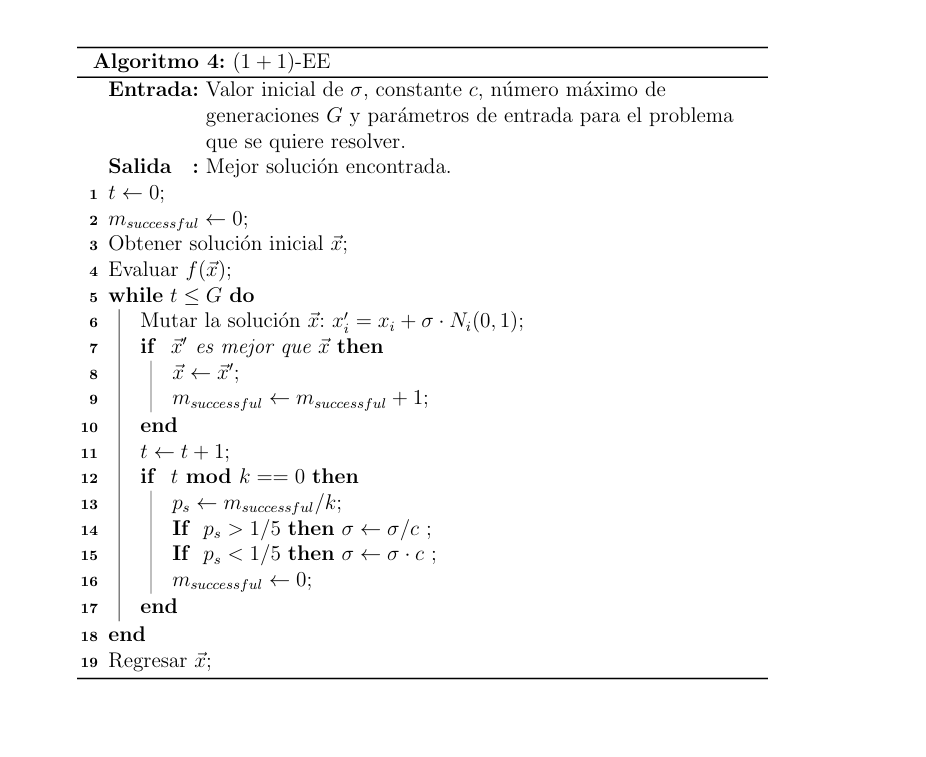

In [14]:
import numpy as np
import random as rd
import math


In [6]:
def Ackley(x: np.ndarray) :
    n = x.size
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n))
    term2 = -np.exp(np.sum(np.cos(2 * np.pi * x)) / n)
    return term1 + term2 + 20 + np.e

In [ ]:
def one_EE(n: int,
           sigma0: float,
            c: float,
                    G: int,
                    k: int,
                    lower: float = -30.0,
                    upper: float =  30.0,
                    seed: int = None):

    if seed is not None:
        np.random.seed(seed)
    
    # inicializamos
    sigma = sigma0
    x      = np.random.uniform(lower, upper, size=n)
    f_x    = Ackley(x)
    m_exitosas = 0  # contador de mutaciones exitosas
    
    for t in range(1, G+1):
        #  mutación
        x_prime = x + sigma * np.random.randn(n)
        x_prime = np.clip(x_prime, lower, upper)
        f_p     = Ackley(x_prime)
        
        #  seleccionamos (si es mejor, lo acepto)
        if f_p < f_x:
            x    = x_prime
            f_x  = f_p
            m_exitosas += 1
        
        # cada k pasos: regla 1/5 (adaptación de sigma)
        if t % k == 0:
            p_s = m_exitosas / k
            if   p_s > 1/5:
                sigma = sigma / c   
            elif p_s < 1/5:
                sigma = sigma * c   
            m_exitosas = 0
    
    return x, f_x


if __name__ == "__main__":
        # Ejemplo
        n       = 5       # dimensión
        sigma0  = 1.0     # sigma inicial
        c       = 1.5     # factor de adaptación
        G       = 500     # generaciones
        k       = 20      # cada 20 iteraciones adaptamos sigma
        seed    = 123       # reproducibilidad

        x_best, f_best = one_EE(n, sigma0, c, G, k, -30, 30, seed)

        print("Mejor solución encontrada:")
        print(x_best)
        print(f"f(x) = {f_best:.6f}")  

Mejor solución encontrada:
[ 0.06244523 -0.17760559  0.66634603  0.07547281 -1.22687686]
f(x) = 3.628148


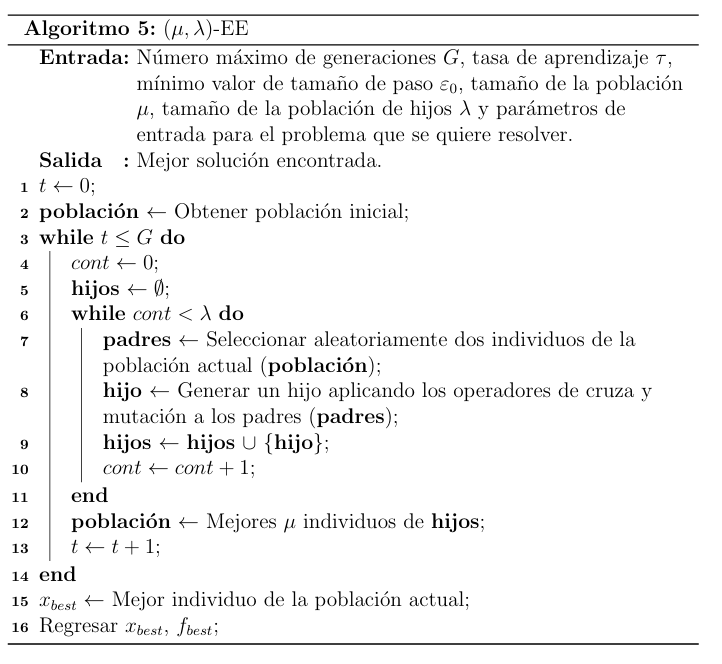

      n    : dimensión del problema
      mu   : tamaño de población de padres
      lam  : número de hijos por generación
      G    : número de generaciones
      tau  : tasa de aprendizaje para σ 
      eps0 : σ mínimo permitido
      lower, upper : dominio de las x_i
      seed : semilla opcional
      Debemos retornar:
          x_best, f_best
    

In [13]:
def mu_lambda_E(n: int, mu: int, lam: int,G: int,tau: float, eps0: float,lower: float = -30.0, upper: float =  30.0, seed: int = None):
    
     # seleccionamos los padres usando np.random.randint
    
    if seed is not None:
        np.random.seed(seed)
    
    # Inicializamos de la población de padres
    pop = []
    for _ in range(mu):
        x     = np.random.uniform(lower, upper, size=n)
        sigma = np.random.uniform(0.1, 1.0,      size=n)
        pop.append((x, sigma, Ackley(x)))
    
    # iniciamos las generaciones
    for t in range(1, G+1):
        hijos = []
        for _ in range(lam):
            # seleccionams de forma aleatoria dos padres
            idx1 = np.random.randint(0, mu)
            idx2 = np.random.randint(0, mu)
            x1, σ1, _ = pop[idx1]
            x2, σ2, _ = pop[idx2]
            
            # recombinación 
            x_rec     = 0.5 * (x1 + x2)
            sigma_rec = 0.5 * (σ1 + σ2)
            
            # Auto‐adaptacion log‐normal de sigma
            # generamos un número aleatorio 
            sigma_off = sigma_rec * np.exp(tau * np.random.randn(n))
            sigma_off = np.maximum(sigma_off, eps0)
            
            # mutación aditiva de x
            x_off = x_rec + sigma_off * np.random.randn(n)
            x_off = np.clip(x_off, lower, upper)
            
            # e) evaluamos y almacenamos los hijos
            hijos.append((x_off, sigma_off, Ackley(x_off)))
        
        #  conservamos los μ mejores hijos
        hijos.sort(key=lambda ind: ind[2])  # orden ascendente según f(x)
        pop = hijos[:mu]
    
    # Regresamos el mejor individuo de la población
    # (el primero de la lista, ya que está ordenada)
    best = min(pop, key=lambda ind: ind[2])
    return best[0], best[2]


if __name__ == "__main__":
    # ejemplo
    n      = 5               # dimensión
    mu     = 30              # número de padres
    lam    = 200             # número de hijos
    G      = 500             # generaciones
    tau    = 1 / np.sqrt(n)  # factor de aprendizaje
    eps0   = 1e-3            # sigma mínimo
    seed   = 42              # semilla para reproducibilidad

    x_best, f_best = mu_lambda_E(n, mu, lam, G, tau, eps0, -30, 30, seed)
    print("Mejor solución encontrada:")
    print(x_best)
    print(f"f(x) = {f_best:.6f}")


Mejor solución encontrada:
[ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
f(x) = 0.002457


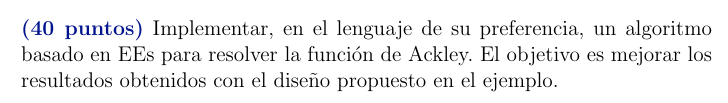

# (μ+λ,k)-EE con envejecimiento por edad 𝑘 

Del paper https://dl.acm.org/doi/10.1145/1143997.1144150

### ¿Cómo funciona k?

La población se forma uniendo a los μ mejores padres con sus λ hijos generados. Tras cada generación, a cada individuo se le incrementa en uno su “edad” 𝑘. Si un individuo supera la edad límite definida en los parámetros y no es el mejor de toda la población, se elimina y se rellena ese hueco con una solución aleatoria nueva.


### Mi opinión sobre esta variante:

Previene el estancamiento, ya que constantemente, un individuo bueno pero no óptimo puede quedarse mucho en la población, consumiendo recursos y bloqueando la aparición de nuevos candidatos, y con el envejecimiento forzamos una renovación constante, permitiendo que otras regiones del espacio de búsqueda reciban oportunidades.

Mantiene  siempre al mejor, que conserva su lugar independientemente de su edad lo que ayuda a  aseguramos de no perder nuestra mejor aproximación actual, pero quitamos a los demás viejos para explorar.

Es más diverso ya que incorpora individuos totalmente aleatorios cuando eliminamos a los mayores inyecta variedad genética y puede desencadenar saltos a áreas del espacio que antes no se exploraban.

El valor de la edad máxima k es sensible, ya que si es demasiado bajo, estamos pasando demasiado rápido la población y no permitimos que soluciones buenas mejoren y si es muy alto, casi nunca entra en juego y la estrategia se comporta igual que un (μ+λ)-EE clásico.

In [16]:
def initialize_population(mu: int, n: int,lower: float, upper: float,seed: int = None):
    # Inicializa una población de mu individuos aleatorios
    # cada uno con n dimensiones y sigma aleatorio
    if seed is not None:
        np.random.seed(seed)
    pop = []
    for _ in range(mu):
        x     = np.random.uniform(lower, upper, size=n)
        sigma = np.random.uniform(0.1, 1.0,      size=n)
        fit   = Ackley(x)
        pop.append({'x': x, 'sigma': sigma, 'fitness': fit, 'age': 0})
    return pop

def mu_lambda_new(n: int,
                       mu: int,
                       lam: int,
                       G: int,
                       tau: float,
                       eps0: float,
                       age_limit: int,
                       lower: float = -30.0,
                       upper: float =  30.0,
                       seed: int = None):
    
    #  Inicializamos la  población de padres
    pop = initialize_population(mu, n, lower, upper, seed)
    
    #  generaciones
    for gen in range(1, G+1):
        hijos = []
        # generar mu hujos
        for _ in range(lam):
            # seleccionamos dos padres al azar (con reemplazo)
            i1 = np.random.randint(0, mu)
            i2 = np.random.randint(0, mu)
            p1, p2 = pop[i1], pop[i2]
            
            # Recombinación 
            x_rec     = 0.5 * (p1['x'] + p2['x'])
            sigma_rec = 0.5 * (p1['sigma'] + p2['sigma'])
            
            # Auto-adaptación log-normal de sigma
            sigma_off = sigma_rec * np.exp(tau * np.random.randn(n))
            sigma_off = np.maximum(sigma_off, eps0)
            
            # Mutación aditiva de x
            x_off = x_rec + sigma_off * np.random.randn(n)
            x_off = np.clip(x_off, lower, upper)
            
            # Evaluación del hijo
            fit_off = Ackley(x_off)
            hijos.append({'x': x_off, 'sigma': sigma_off,
                          'fitness': fit_off, 'age': 0})
        
        # Reemplazamos para quedarnos con los mu  mejores hijos
        hijos.sort(key=lambda ind: ind['fitness'])  # ordenar ascendiente (minimizar)
        pop = hijos[:mu]
        
        # Aplicamos el Envejecimiento es decir incrementar edad de cada padre
        for ind in pop:
            ind['age'] += 1
        
        # Eliminamos los padres que superen age_limit
        pop = [ind for ind in pop if ind['age'] < age_limit]
        
        #  Rellenamos con nuevos individuos aleatorios
        faltan = mu - len(pop)
        if faltan > 0:
            nuevos = initialize_population(faltan, n, lower, upper, seed=None)
            pop.extend(nuevos)
    
    # Devolvemos el mejor individuo de la población
    # (el primero de la lista, ya que está ordenada)
    best = min(pop, key=lambda ind: ind['fitness'])
    return best['x'], best['fitness']

if __name__ == "__main__":
    # Parámetros de ejemplo
    n         = 5                 # dimensión de x
    mu        = 30                # padres
    lam       = 200               # hijos por generación
    G         = 500               # generaciones totales
    tau       = 1/np.sqrt(n)      # tasa log-normal para σ
    eps0      = 1e-3              # σ mínimo
    age_limit = 10                # edad máxima antes de eliminar
    lower     = -30.0             # cota inferior de x
    upper     = 30.0              # cota superior de x
    seed      = 42                # semilla para reproducir resultados

    x_best, f_best = mu_lambda_new(
        n, mu, lam, G, tau, eps0, age_limit, lower, upper, seed
    )

    print("Mejor solución encontrada:")
    print(x_best)
    print(f"f(x) = {f_best:.6f}")


Mejor solución encontrada:
[ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
f(x) = 0.002457


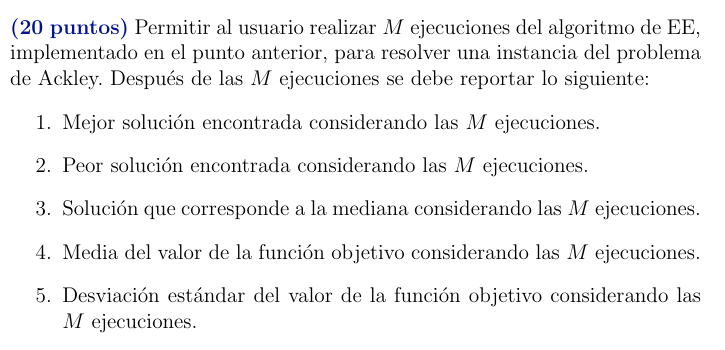

In [18]:
def m_ejecuciones(n: int, mu: int, lam: int, G: int, tau: float, eps0: float, lower: float = -30.0, upper: float =  30.0, seed: int = None):
 
    results = []
    for i in range(M):
      
        s = None if seed is None else seed + i
        # Ejecutamos el algoritmo mu_lambda_E
        x, f = mu_lambda_E(n, mu, lam, G, tau, eps0, lower, upper, seed=s)
        results.append((x, f))

    # Ordenar por valor de f
    results_sorted = sorted(results, key=lambda t: t[1])
    best_x, best_f     = results_sorted[0]
    worst_x, worst_f   = results_sorted[-1]
    median_x, median_f = results_sorted[M//2]

    f_vals = np.array([f for _, f in results])
    mean_f = np.mean(f_vals)
    std_f  = np.std(f_vals)

    return {
        'best':   (best_x,     best_f),
        'worst':  (worst_x,    worst_f),
        'median': (median_x,   median_f),
        'mean_f': mean_f,
        'std_f':  std_f
    }

if __name__ == "__main__":
    n      = 5               
    mu     = 30               
    lam    = 200              
    G      = 500              
    tau    = 1/np.sqrt(n)     
    eps0   = 1e-3            
    M      = 30               
    seed   = 42              

    # Ejecutar M veces 
    stats = m_ejecuciones(n, mu, lam, G, tau, eps0, -30, 30, seed)

    # resultados
    xb, fb     = stats['best']
    xw, fw     = stats['worst']
    xm, fm     = stats['median']
    mean_f     = stats['mean_f']
    std_f      = stats['std_f']

    print(f"--- Estadísticas tras {M} ejecuciones (n={n}) ---\n")
    print(f"Mejor corrida:\n x = {xb}\n f(x) = {fb:.6f}\n")
    print(f"Peor corrida:\n x = {xw}\n f(x) = {fw:.6f}\n")
    print(f"Mediana corrida:\n x = {xm}\n f(x) = {fm:.6f}\n")
    print(f"Media de f:      {mean_f:.6f}")
    print(f"Desvíaestándar: {std_f:.6f}")

--- Estadísticas tras 30 ejecuciones (n=5) ---

Mejor corrida:
 x = [ 1.81702706e-04 -7.22382055e-05 -1.29999893e-04 -3.61619061e-04
 -1.13204086e-04]
 f(x) = 0.000800

Peor corrida:
 x = [ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
 f(x) = 0.002457

Mediana corrida:
 x = [-4.44946045e-04  3.96085603e-04 -5.89133650e-04 -4.14064363e-05
  2.98085601e-04]
 f(x) = 0.001601

Media de f:      0.001617
Desvíaestándar: 0.000389


In [19]:
# Ejecuciones para el algoritmo con envejecimiento
def m_ejecuciones_con_edad(n: int, mu: int, lam: int, G: int, tau: float, eps0: float, age_limit: int, lower: float = -30.0, upper: float =  30.0, seed: int = None):
    results = []
    for i in range(M):
        s = None if seed is None else seed + i
        x, f = mu_lambda_new(n, mu, lam, G, tau, eps0, age_limit,
                             lower, upper, seed=s)
        results.append((x, f))
    
    # ordenar por f
    results.sort(key=lambda t: t[1])
    best_x, best_f     = results[0]
    worst_x, worst_f   = results[-1]
    median_x, median_f = results[M//2]
    
    f_vals = np.array([f for _, f in results])
    mean_f = np.mean(f_vals)
    std_f  = np.std(f_vals)
    
    return {
        'best':   (best_x,     best_f),
        'worst':  (worst_x,    worst_f),
        'median': (median_x,   median_f),
        'mean_f': mean_f,
        'std_f':  std_f
    }

if __name__ == "__main__":
   
    n         = 5
    mu        = 30
    lam       = 200
    G         = 500
    tau       = 1/np.sqrt(n)
    eps0      = 1e-3
    age_limit = 10
    M         = 30
    seed      = 42
    
    stats = m_ejecuciones_con_edad(
        n, mu, lam, G, tau, eps0, age_limit, -30, 30, seed
    )
    
    xb, fb     = stats['best']
    xw, fw     = stats['worst']
    xm, fm     = stats['median']
    mean_f     = stats['mean_f']
    std_f      = stats['std_f']
    
    print(f"--- Estadísticas tras {M} ejecuciones (n={n}) ---\n")
    print(f"Mejor corrida:\n x = {xb}\n f(x) = {fb:.6f}\n")
    print(f"Peor corrida:\n x = {xw}\n f(x) = {fw:.6f}\n")
    print(f"Mediana corrida:\n x = {xm}\n f(x) = {fm:.6f}\n")
    print(f"Media de f:      {mean_f:.6f}")
    print(f"Desvariación estándar: {std_f:.6f}")

--- Estadísticas tras 30 ejecuciones (n=5) ---

Mejor corrida:
 x = [ 1.81702706e-04 -7.22382055e-05 -1.29999893e-04 -3.61619061e-04
 -1.13204086e-04]
 f(x) = 0.000800

Peor corrida:
 x = [ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
 f(x) = 0.002457

Mediana corrida:
 x = [-4.44946045e-04  3.96085603e-04 -5.89133650e-04 -4.14064363e-05
  2.98085601e-04]
 f(x) = 0.001601

Media de f:      0.001617
Desvariación estándar: 0.000389


In [ ]:
# M ejecuciones para el algoritmo (1+1)-ES
def m_oneEE(n: int, sigma0: float, c: float, G: int, k: int, M: int, lower: float = -30.0, upper: float =  30.0, seed: int = None):
 
    results = []
    for i in range(M):
        s = None if seed is None else seed + i
        x, f = one_EE(n, sigma0, c, G, k, lower, upper, seed=s)
        results.append((x, f))

    # Ordenar según f (menor = mejor)
    results.sort(key=lambda t: t[1])
    best_x, best_f     = results[0]
    worst_x, worst_f   = results[-1]
    median_x, median_f = results[M//2]

    f_vals = np.array([f for _, f in results])
    mean_f = np.mean(f_vals)
    std_f  = np.std(f_vals)

    return {
        'best':   (best_x,     best_f),
        'worst':  (worst_x,    worst_f),
        'median': (median_x,   median_f),
        'mean_f': mean_f,
        'std_f':  std_f
    }


if __name__ == "__main__":
 
    n       = 5
    sigma0  = 1.0
    c       = 1.5
    G       = 500
    k       = 20
    lower   = -30.0
    upper   = 30.0
    seed    = 123

    # Número de corridas
    M = 30

    stats = m_oneEE(   
        n, sigma0, c, G, k, M, lower, upper, seed
    )

    xb, fb     = stats['best']
    xw, fw     = stats['worst']
    xm, fm     = stats['median']
    mean_f     = stats['mean_f']
    std_f      = stats['std_f']

    print(f"--- Estadísticas {(1+1)}-ES tras {M} ejecuciones (n={n}) ---\n")
    print(f"Mejor corrida:\n x = {xb}\n f(x) = {fb:.6f}\n")
    print(f"Peor corrida:\n x = {xw}\n f(x) = {fw:.6f}\n")
    print(f"Mediana corrida:\n x = {xm}\n f(x) = {fm:.6f}\n")
    print(f"Media de f:      {mean_f:.6f}")
    print(f"Desvío estándar: {std_f:.6f}")

--- Estadísticas 2-ES tras 30 ejecuciones (n=5) ---

Mejor corrida:
 x = [-0.18805405  0.04727025 -0.35718177  0.34338416  0.3099756 ]
 f(x) = 2.831085

Peor corrida:
 x = [-30.         -30.          30.          12.02054925  30.        ]
 f(x) = 19.920566

Mediana corrida:
 x = [ 6.00001867 -2.32724026 -6.09285654  1.63806313  2.6701196 ]
 f(x) = 13.041093

Media de f:      12.303736
Desvío estándar: 5.669254


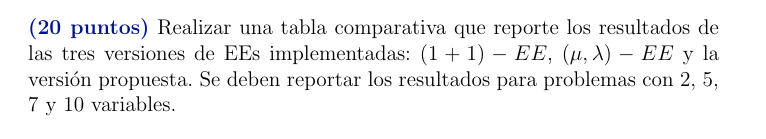

In [25]:
def comparative(n: int, seed: int = None):  # Para comparar los algoritmos con  2, 5, 7 y 10 variables
    
    print(f"\n=== {n} variables ===")
    s = seed

    # (1+1)-ES
    x1, f1 = one_EE(n, sigma0=1.0, c=1.5, G=500, k=20,
                    lower=-30.0, upper=30.0, seed=s)
    print("(1+1)-ES:")
    print(" x =", x1)
    print(f" f(x) = {f1:.6f}")

    # (μ,λ)-ES
    x2, f2 = mu_lambda_E(n, mu=30, lam=200, G=500,
                         tau=1/np.sqrt(n), eps0=1e-3,
                         lower=-30.0, upper=30.0, seed=s)
    print("(μ,λ)-ES:")
    print(" x =", x2)
    print(f" f(x) = {f2:.6f}")

    # (μ,λ)-EE + edad
    x3, f3 = mu_lambda_new(n, mu=30, lam=200, G=500,
                           tau=1/np.sqrt(n), eps0=1e-3,
                           age_limit=10,
                           lower=-30.0, upper=30.0, seed=s)
    print("(μ,λ)-EE + edad:")
    print(" x =", x3)
    print(f" f(x) = {f3:.6f}")

    return f1, f2, f3

def m_runs(func, kwargs, M=30, base_seed=42):
    vals = []
    for i in range(M):
        _, f = func(**{**kwargs, 'seed': base_seed + i})
        vals.append(f)
    arr = np.sort(np.array(vals))
    return {
        'best':   arr[0],
        'worst':  arr[-1],
        'median': arr[M//2],
        'mean':   arr.mean(),
        'std':    arr.std()
    }

if __name__ == "__main__":
    dims = [2, 5, 7, 10]
    M    = 30
    seed = 42

    #  Variables individuales para cada algoritmo
    all_va = {}
    for n in dims:
        f1, f2, f3 = comparative(n, seed=seed)
        all_va[n] = {'(1+1)-ES':f1, '(μ,λ)-ES':f2, '(μ,λ)-ES+age':f3}

    



=== 2 variables ===
(1+1)-ES:
 x = [1.18588243 0.42554303]
 f(x) = 5.203837
(μ,λ)-ES:
 x = [-2.71999748e-05 -5.50455644e-05]
 f(x) = 0.000174
(μ,λ)-EE + edad:
 x = [-2.71999748e-05 -5.50455644e-05]
 f(x) = 0.000174

=== 5 variables ===
(1+1)-ES:
 x = [ 1.16839622 -2.49256911  1.04290433  0.61173995  2.52270915]
 f(x) = 7.867836
(μ,λ)-ES:
 x = [ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
 f(x) = 0.002457
(μ,λ)-EE + edad:
 x = [ 1.26516381e-03 -4.38119135e-04  3.67640756e-05  9.72557931e-05
 -2.31030611e-04]
 f(x) = 0.002457

=== 7 variables ===
(1+1)-ES:
 x = [  0.92279964  -9.79551814  -3.94874838  30.          -0.29494529
  -8.79761333 -19.14364773]
 f(x) = 19.892044
(μ,λ)-ES:
 x = [ 0.00084966 -0.00029782  0.00076954  0.00090813 -0.00050814  0.00087105
  0.0002253 ]
 f(x) = 0.002769
(μ,λ)-EE + edad:
 x = [ 0.00084966 -0.00029782  0.00076954  0.00090813 -0.00050814  0.00087105
  0.0002253 ]
 f(x) = 0.002769

=== 10 variables ===
(1+1)-ES:
 x = [ 

In [ ]:
import pandas as pd

data = [
    {"n": 2, "Algoritmo": "(1+1)-ES", "x": "[1.18588243, 0.42554303]", "f(x)": 5.203837},
    {"n": 2, "Algoritmo": "(μ,λ)-ES", "x": "[-2.71999748e-05, -5.50455644e-05]", "f(x)": 0.000174},
    {"n": 2, "Algoritmo": "(μ,λ)-ES+age", "x": "[-2.71999748e-05, -5.50455644e-05]", "f(x)": 0.000174},
    {"n": 5, "Algoritmo": "(1+1)-ES", "x": "[1.16839622, -2.49256911, 1.04290433, 0.61173995, 2.52270915]", "f(x)": 7.867836},
    {"n": 5, "Algoritmo": "(μ,λ)-ES", "x": "[0.00126516, -0.00043812, 0.00003676, 0.00009726, -0.00023103]", "f(x)": 0.002457},
    {"n": 5, "Algoritmo": "(μ,λ)-ES+age", "x": "[0.00126516, -0.00043812, 0.00003676, 0.00009726, -0.00023103]", "f(x)": 0.002457},
    {"n": 7, "Algoritmo": "(1+1)-ES", "x": "[0.92279964, -9.79551814, -3.94874838, 30., -0.29494529, -8.79761333, -19.14364773]", "f(x)": 19.892044},
    {"n": 7, "Algoritmo": "(μ,λ)-ES", "x": "[0.00084966, -0.00029782, 0.00076954, 0.00090813, -0.00050814, 0.00087105, 0.00022530]", "f(x)": 0.002769},
    {"n": 7, "Algoritmo": "(μ,λ)-ES+age", "x": "[0.00084966, -0.00029782, 0.00076954, 0.00090813, -0.00050814, 0.00087105, 0.00022530]", "f(x)": 0.002769},
    {"n": 10, "Algoritmo": "(1+1)-ES", "x": "[-6.85899414, 18.76961336, -0.3391783, 0.66243949, -11.08189917, -7.27144077, -13.94653063, 2.92860681, -8.02654008, 15.329145]", "f(x)": 18.889156},
    {"n": 10, "Algoritmo": "(μ,λ)-ES", "x": "[0.00034007, -0.00008306, -0.00012995, 0.00185835, 0.00056580, 0.00097068, -0.00065312, -0.00137071, -0.00092411, -0.00023318]", "f(x)": 0.003636},
    {"n": 10, "Algoritmo": "(μ,λ)-ES+age", "x": "[0.00034007, -0.00008306, -0.00012995, 0.00185835, 0.00056580, 0.00097068, -0.00065312, -0.00137071, -0.00092411, -0.00023318]", "f(x)": 0.003636},
]

df = pd.DataFrame(data)

print(df.to_markdown(index=False, floatfmt=".6f"))


|   n | Algoritmo    | x                                                                                                                               |      f(x) |
|----:|:-------------|:--------------------------------------------------------------------------------------------------------------------------------|----------:|
|   2 | (1+1)-ES     | [1.18588243, 0.42554303]                                                                                                        |  5.203837 |
|   2 | (μ,λ)-ES     | [-2.71999748e-05, -5.50455644e-05]                                                                                              |  0.000174 |
|   2 | (μ,λ)-ES+age | [-2.71999748e-05, -5.50455644e-05]                                                                                              |  0.000174 |
|   5 | (1+1)-ES     | [1.16839622, -2.49256911, 1.04290433, 0.61173995, 2.52270915]                                                                   |  7.867836 |
|   5 | (μ